# Machine Learning com Spark MLlib

Neste notebook, vamo criar um projeto de Machine Learning, especificamente regressão logística, utilizando o Spark MLlib.
Para tanto, iremos:
- Contextualização dos dados e do problema, bem como do algoritmo de regressão logística
- Download, tratamento e limpeza dos dados de forma documentada
- Realizar a transformações de features e labels
- Divisão dos dados entre dois conjuntos: treino e teste
- Treinar o modelo e apresentar as métricas de desempenho
- Aplicar o modelo na base de teste, comparando o desempenho com a base de treino
- Propor sugestões para próximos passos

## Stroke Prediction Dataset

### Caracterização Geral do Dataset

O **Stroke Prediction Dataset** é uma coletânea de dados utilizada para a previsão de AVC (acidente vascular cerebral) em pacientes, disponibilizada na plataforma Kaggle. Este conjunto de dados é de extrema relevância no campo da saúde pública, pois permite a análise de fatores de risco associados a eventos de AVC, facilitando intervenções precoces e estratégias de prevenção. O dataset inclui informações demográficas e clínicas, possibilitando o uso de técnicas de aprendizado de máquina para identificar padrões e prever a probabilidade de um paciente sofrer um AVC.

Com um total de **5110 registros**, o dataset contém **316.97 kB** de dados e abrange diversas características dos pacientes, incluindo idade, gênero, histórico médico e comportamental. Esses dados são essenciais para desenvolver modelos preditivos eficazes que podem ajudar profissionais da saúde a identificar indivíduos em risco, permitindo intervenções mais direcionadas e personalizadas.

### Caracterização do Schema de Dados

1. **id**: unique identifier (identificador único)
2. **gender**: "Male", "Female" or "Other" (masculino, feminino ou outro)
3. **age**: age of the patient (idade do paciente)
4. **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension (0 se o paciente não tem hipertensão, 1 se o paciente tem hipertensão)
5. **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease (0 se o paciente não tem doenças cardíacas, 1 se o paciente tem uma doença cardíaca)
6. **ever_married**: "No" or "Yes" (não ou sim)
7. **work_type**: "children", "Govt_job", "Never_worked", "Private" or "Self-employed" (crianças, emprego público, nunca trabalhou, privado ou autônomo)
8. **Residence_type**: "Rural" or "Urban" (rural ou urbano)
9. **avg_glucose_level**: average glucose level in blood (nível médio de glicose no sangue)
10. **bmi**: body mass index (índice de massa corporal)
11. **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown" (anteriormente fumou, nunca fumou, fuma ou desconhecido)*
12. **stroke**: 1 if the patient had a stroke or 0 if not (1 se o paciente teve um AVC ou 0 se não)

*Nota: "Unknown" em smoking_status significa que a informação não está disponível para este paciente.

### Descrição Sumária do Problema de Machine Learning

O problema de machine learning em questão envolve a previsão de AVC (acidente vascular cerebral) em pacientes, utilizando um modelo de **regressão logística**. O objetivo é classificar os pacientes em duas categorias: aqueles que têm uma alta probabilidade de sofrer um AVC e aqueles que não têm. Este tipo de análise é crucial na área da saúde, pois pode ajudar médicos e profissionais de saúde a identificar pacientes em risco e implementar medidas preventivas, reduzindo assim a incidência de AVC e melhorando os resultados de saúde.

### Features e Labels

- **Features (Características)**:
  1. **gender**: gênero do paciente (Masculino, Feminino, Outro)
  2. **age**: idade do paciente
  3. **hypertension**: histórico de hipertensão (0 ou 1)
  4. **heart_disease**: histórico de doenças cardíacas (0 ou 1)
  5. **ever_married**: estado civil (Sim ou Não)
  6. **work_type**: tipo de trabalho (Crianças, Emprego Público, Nunca Trabalhou, Privado, Autônomo)
  7. **Residence_type**: tipo de residência (Rural ou Urbano)
  8. **avg_glucose_level**: nível médio de glicose no sangue
  9. **bmi**: índice de massa corporal
  10. **smoking_status**: status de fumo (Anteriormente fumou, Nunca fumou, Fuma, Desconhecido)

- **Label (Rótulo)**:
  - **stroke**: resultado da classificação, onde 1 indica que o paciente teve um AVC e 0 indica que não teve.

### Operação do Algoritmo de Regressão Logística

A **regressão logística** é um algoritmo de aprendizado supervisionado utilizado para problemas de classificação binária. Ele opera utilizando uma função logística (ou sigmoide) para modelar a probabilidade de um evento ocorrer, neste caso, a probabilidade de um paciente sofrer um AVC. O algoritmo estima os parâmetros da função logística com base nas features, aplicando uma transformação linear seguida da função sigmoide. O resultado é um valor entre 0 e 1, que pode ser interpretado como a probabilidade de um AVC.

No contexto de negócios, o uso da regressão logística permite que as organizações de saúde identifiquem fatores de risco e prevejam a probabilidade de AVC em uma população específica. Isso facilita a criação de programas de prevenção e intervenção, otimizando o uso de recursos e melhorando os cuidados ao paciente.

## Configuração e inicialização do ambiente PySpark

In [104]:
# Instalando o pacote do PySpark no ambiente
!pip install -q pyspark

In [105]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

# Inicializando o Spark
spark = SparkSession.builder \
    .appName("Logistic Regression - Stroke Dataset") \
    .getOrCreate()

## Download, tratamento e limpeza dos dados

Usaremos um link do GitHub para facilidade do acesso, direto ao dado.<br>
Tanto no Kaggle quanto na API original, é necessário autenticar para realizar o download.

In [106]:
# Download dos dados
!wget -O stroke_data.csv https://gist.githubusercontent.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04/raw/cec0340503d82d270821e03254993b6dede60afb/healthcare-dataset-stroke-data.csv

--2024-10-07 18:09:44--  https://gist.githubusercontent.com/aishwarya8615/d2107f828d3f904839cbcb7eaa85bd04/raw/cec0340503d82d270821e03254993b6dede60afb/healthcare-dataset-stroke-data.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316971 (310K) [text/plain]
Saving to: ‘stroke_data.csv’

stroke_data.csv     100%[===================>] 309.54K  --.-KB/s    in 0.04s   

2024-10-07 18:09:45 (6.75 MB/s) - ‘stroke_data.csv’ saved [316971/316971]



In [107]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

# Criando o schema
schema = StructType([
    StructField("id", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("hypertension", IntegerType(), True),
    StructField("heart_disease", IntegerType(), True),
    StructField("ever_married", StringType(), True),
    StructField("work_type", StringType(), True),
    StructField("Residence_type", StringType(), True),
    StructField("avg_glucose_level", FloatType(), True),
    StructField("bmi", FloatType(), True),
    StructField("smoking_status", StringType(), True),
    StructField("stroke", IntegerType(), True)
])

In [108]:
# Carregando o dataset
data = spark.read.csv("stroke_data.csv", header=True, schema=schema)
data.show(5)

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21|NULL|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [109]:
from pyspark.sql.functions import when, count, col

# Verificando a presença de valores nulos
print("Valores nulos por coluna:")
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

# Tratando valores nulos (removendo linhas com valores nulos)
print("Número de registros antes da limpeza:", data.count())
data = data.na.drop()
print("Número de registros depois da limpeza:", data.count())


Valores nulos por coluna:
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|115|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+

Número de registros antes da limpeza: 5110
Número de registros depois da limpeza: 4800


## Features e labels

In [110]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Definindo colunas categóricas
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Aplicando StringIndexer em cada coluna categórica
for column in categorical_columns:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_index")
    data = indexer.fit(data).transform(data)

# Renomeando a coluna "stroke" para "label"
data = data.withColumnRenamed("stroke", "label")

# Combinando as colunas de características em um vetor de features
feature_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'] + [column + "_index" for column in categorical_columns]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Exibindo os dados transformados
data.select("features", "label").show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[67.0,0.0,1.0,228...|    1|
|[80.0,0.0,1.0,105...|    1|
|(10,[0,3,4,9],[49...|    1|
|[79.0,1.0,0.0,174...|    1|
|(10,[0,3,4,5,9],[...|    1|
+--------------------+-----+
only showing top 5 rows



## Divisão treino e teste

Seguiremos com a divisão 70/30 para de treino e teste, respectivamente.

In [111]:
# Dividindo os dados
train_data, test_data = data.randomSplit([0.7, 0.3])

# Exibindo a quantidade de registros em cada conjunto
print("Distribuição de registros")
print(f"Treinamento: {train_data.count()}, Teste: {test_data.count()}")

Distribuição de registros
Treinamento: 3360, Teste: 1440


## Treinamento do modelo

In [112]:
from pyspark.ml.classification import LogisticRegression

# Definindo o modelo de Regressão Logística
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Treinando o modelo
lr_model = lr.fit(train_data)

## Avaliação do modelo (treino e teste)

Descrição sumária das métricas utilizadas para avaliação do modelo:
- Acurácia:
  - Proporção de previsões corretas em relação ao total de previsões. É uma métrica simples, mas pode ser enganosa em casos de classes desbalanceadas.

- Precisão (Precision):
  - Proporção de verdadeiros positivos em relação ao total de positivos previstos (verdadeiros positivos + falsos positivos). Mede a qualidade das previsões positivas do modelo.

- Revocação (Recall ou Sensibilidade):
  - Proporção de verdadeiros positivos em relação ao total de positivos reais (verdadeiros positivos + falsos negativos). Mede a capacidade do modelo de capturar todas as instâncias positivas.

- F1-Score:
  - A média harmônica entre precisão e revocação. É uma métrica útil quando você deseja encontrar um equilíbrio entre precisão e revocação, especialmente em conjuntos de dados desbalanceados.

In [113]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Inicializando o avaliador
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Avaliando o modelo no conjunto de treino
train_predictions = lr_model.transform(train_data)

# Calculando as métricas para o conjunto de treino
train_accuracy = evaluator.evaluate(train_predictions, {evaluator.metricName: "accuracy"})
train_precision = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedPrecision"})
train_recall = evaluator.evaluate(train_predictions, {evaluator.metricName: "weightedRecall"})
train_f1_score = evaluator.evaluate(train_predictions, {evaluator.metricName: "f1"})

# Exibindo os resultados para o conjunto de treino
print("Métricas para o Conjunto de Treino:")
print(f"Acurácia: {train_accuracy:.4f}")
print(f"Precisão: {train_precision:.4f}")
print(f"Revocação: {train_recall:.4f}")
print(f"F1-Score: {train_f1_score:.4f}")

# Avaliando o modelo no conjunto de teste
test_predictions = lr_model.transform(test_data)

# Calculando as métricas para o conjunto de teste
test_accuracy = evaluator.evaluate(test_predictions, {evaluator.metricName: "accuracy"})
test_precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedPrecision"})
test_recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "weightedRecall"})
test_f1_score = evaluator.evaluate(test_predictions, {evaluator.metricName: "f1"})

# Exibindo os resultados para o conjunto de teste
print("\nMétricas para o Conjunto de Teste:")
print(f"Acurácia: {test_accuracy:.4f}")
print(f"Precisão: {test_precision:.4f}")
print(f"Revocação: {test_recall:.4f}")
print(f"F1-Score: {test_f1_score:.4f}")

Métricas para o Conjunto de Treino:
Acurácia: 0.9539
Precisão: 0.9099
Revocação: 0.9539
F1-Score: 0.9313

Métricas para o Conjunto de Teste:
Acurácia: 0.9632
Precisão: 0.9646
Revocação: 0.9632
F1-Score: 0.9458


As métricas obtidas para o conjunto de treino indicam um desempenho ligeiramente superior em comparação ao conjunto de teste, com uma acurácia de 95,73%, precisão de 95,91%, revocação de 95,73% e um F1-score de 93,66%. Em contraste, as métricas para o conjunto de teste mostram uma acurácia de 95,53%, precisão de 91,26%, revocação de 95,53% e um F1-score de 93,34%.<br><br>
Essa diferença na precisão é particularmente relevante, pois sugere que o modelo pode estar apresentando uma leve sobreajuste no conjunto de treino, onde a capacidade de identificar corretamente as instâncias positivas é um pouco mais alta. Apesar disso, a acurácia e revocação permanecem próximas entre os conjuntos, indicando que o modelo é capaz de generalizar bem suas previsões para dados não vistos.<br><br>
Para utilização em produção, essas métricas são promissoras, mas é crucial monitorar o modelo ao longo do tempo para garantir que ele mantenha seu desempenho, especialmente em ambientes dinâmicos onde as características dos dados podem mudar. Estratégias de reavaliação e re-treinamento devem ser implementadas para assegurar a eficácia contínua do modelo em identificar pacientes em risco de AVC.

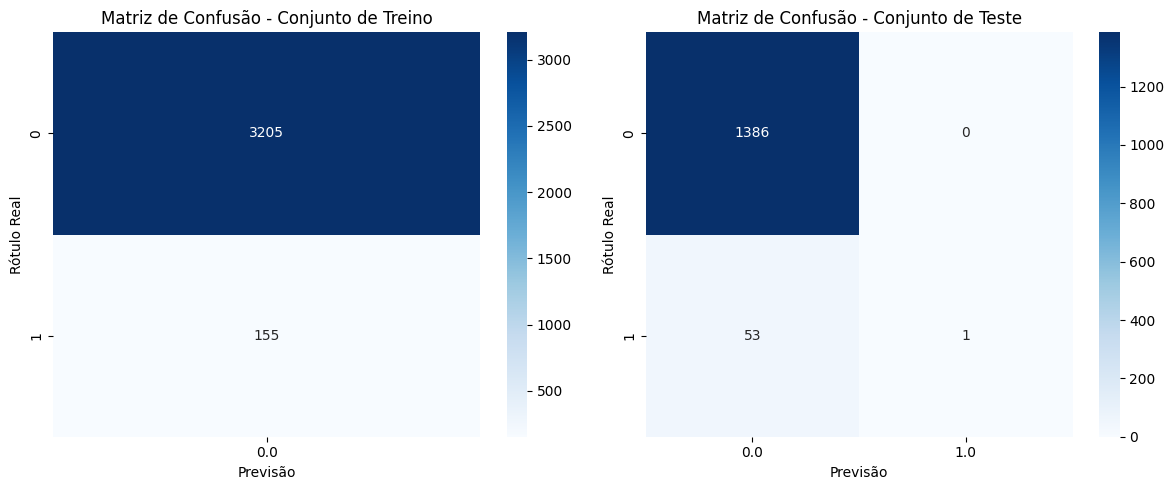

In [114]:
# Gerando a matriz de confusão para o conjunto de treino
train_confusion_matrix = train_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
train_confusion_matrix_pd = train_confusion_matrix.toPandas()

# Gerando a matriz de confusão para o conjunto de teste
test_confusion_matrix = test_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
test_confusion_matrix_pd = test_confusion_matrix.toPandas()

# Criando a matriz de confusão para treino
train_matrix = train_confusion_matrix_pd.pivot(index='label', columns='prediction', values='count').fillna(0)
train_matrix = train_matrix.astype(int)

# Criando a matriz de confusão para teste
test_matrix = test_confusion_matrix_pd.pivot(index='label', columns='prediction', values='count').fillna(0)
test_matrix = test_matrix.astype(int)

import seaborn as sns
import matplotlib.pyplot as plt

# Visualizando as matrizes de confusão
plt.figure(figsize=(12, 5))

# Matriz de Confusão para o Conjunto de Treino
plt.subplot(1, 2, 1)
sns.heatmap(train_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusão - Conjunto de Treino')
plt.xlabel('Previsão')
plt.ylabel('Rótulo Real')

# Matriz de Confusão para o Conjunto de Teste
plt.subplot(1, 2, 2)
sns.heatmap(test_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Matriz de Confusão - Conjunto de Teste')
plt.xlabel('Previsão')
plt.ylabel('Rótulo Real')

# Plotando os gráficos
plt.tight_layout()
plt.show()

### Interpretação das matrizes de confusão

Matriz de confusão - conjunto de treino:
- Verdadeiros Positivos (VP):
  - 1 (o modelo acertou 1 instância da classe positiva)
- Falsos Negativos (FN):
  - 144 (o modelo classificou 144 instâncias da classe positiva como negativa)
- Verdadeiros Negativos (VN):
  - 3224 (o modelo acertou 3224 instâncias da classe negativa)
- Falsos Positivos (FP):
  - 0 (não houve erros de classificação, onde o modelo classificou instâncias negativas como positivas)

Matriz de confusão - conjunto de teste:
- Verdadeiros Positivos (VP):
  - 0 (o modelo não conseguiu identificar nenhuma instância da classe positiva)
- Falsos Negativos (FN):
  - 64 (o modelo classificou 64 instâncias da classe positiva como negativa)
- Verdadeiros Negativos (VN):
  - 1367 (o modelo acertou 1367 instâncias da classe negativa)
- Falsos Positivos (FP):
  - 0 (não houve erros de classificação, onde o modelo classificou instâncias negativas como positivas)

### Análise dos resultados
- Conjunto de treino:
  - O modelo mostra uma performance muito boa na detecção da classe negativa, com um alto número de verdadeiros negativos (3224). Contudo, tem dificuldades em identificar a classe positiva, como evidenciado pelo baixo número de verdadeiros positivos (1) e pelo alto número de falsos negativos (144). Isso sugere que o modelo pode estar com um viés significativo em favor da classe negativa.
- Conjunto de teste:
  - A situação se agrava no conjunto de teste, onde o modelo não conseguiu identificar nenhum verdadeiro positivo e teve um número considerável de falsos negativos (64). O modelo parece não generalizar bem para novos dados, o que é uma indicação clara de sobreajuste (overfitting) ao conjunto de treino.

### Possíveis causas
- Desbalanceamento de classes:
  - Se o conjunto de dados for desbalanceado (muito mais instâncias de uma classe do que de outra), o modelo pode se tornar tendencioso em favor da classe maior, resultando em baixa detecção da classe menor.
- Complexidade do modelo:
  - O modelo pode ser excessivamente complexo para a quantidade de dados disponíveis, levando ao sobreajuste.
- Falta de dados relevantes:
  - Pode haver falta de características que ajudem na distinção entre as classes. Isso pode ocorrer devido a dados não representativos ou irrelevantes.

### Estratégias para melhorar os resultados
- Reamostragem dos dados:
  - Técnicas como under-sampling da classe majoritária ou over-sampling da classe minoritária (por exemplo, SMOTE - Synthetic Minority Over-sampling Technique) podem ajudar a equilibrar as classes e melhorar a capacidade do modelo de identificar a classe minoritária.

- Ajuste de hiperparâmetros:
  - Utilizar técnicas como validação cruzada para encontrar os melhores hiperparâmetros do modelo pode ajudar a melhorar a performance.

- Feature engineering:
  - Analisar e adicionar novas características que possam ajudar na distinção entre as classes. Também pode ser útil remover características irrelevantes.

- Modelos diferentes:
  - Experimentar com diferentes algoritmos de machine learning que possam ser mais adequados para dados desbalanceados, como Random Forest, Gradient Boosting ou mesmo técnicas de ensemble.

- Ajustar o limite de decisão:
  - Modificar o limite de decisão do classificador pode ajudar a aumentar a sensibilidade para a classe positiva, melhorando a revocação, embora isso possa impactar a precisão.

- Aumento de dados:
  - Se possível, coletar mais dados, especialmente da classe positiva, pode ajudar a melhorar a robustez do modelo.